In [42]:
import requests
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [73]:
def get_crypto(crypto,period='86400'):
    '''
    Parameters
    ----------
    crypto : String
        Ticker for the crypto.
    period : String, optional
        seconds between datapoints. The default is '86400' which stands for 1 day.

    Returns
    -------
    df : DataFrame
        Contains timestamp, open, high, low, close, volume, quotevolume.

    '''
    url_base = 'https://api.cryptowat.ch/markets/'
    url_market = 'binance/'
    url_pair = crypto + 'usdt/'
    url_ohlc = 'ohlc?'
    url_periods = 'periods='+period
    
    url = url_base + url_market + url_pair + url_ohlc + url_periods
    r = requests.get(url)
    data = r.json()
    
    data = data['result'][period]
    
    data_df = {'timestamp':[], 'open':[], 'high':[], 'low':[], 'close':[], 'vol':[], 'quotevol':[]}
    index_df = []
    i = 1
    for day in data:
        data_df['timestamp'].append(day[0])
        data_df['open'].append(day[1])
        data_df['high'].append(day[2])
        data_df['low'].append(day[3])
        data_df['close'].append(day[4])
        data_df['vol'].append(day[5])
        data_df['quotevol'].append(day[6])
        index_df.append(i)
        i += 1
    df = pd.DataFrame(data_df, index=index_df)
    return df

def returns(df):
    return df['close'].pct_change()

def annualize_rets(r, periods_per_year=365):
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def portfolio_return(weights, returns):
    return weights.T @ returns

def cryptodict_dfrets(dic):
    header = dic.keys()
    rets_list = []
    for c in dic:
        rets_list.append(dic[c]['close'].pct_change())
    rets_df = pd.concat(rets_list, axis=1, keys=header)
    
    return rets_df

def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

In [97]:
def minimize_vol(target_return, cryptos, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    
    n = len(cryptos)
    rets_df = cryptodict_dfrets(cryptos)
    
    ann_rets = annualize_rets(rets_df)
    
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n 
    
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (rets_df,),
                        'fun': lambda weights, rets_df: target_return - portfolio_return(weights,ann_rets)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

In [75]:
btc = get_crypto('btc')
eth = get_crypto('eth')

In [76]:
dic = {'btc':btc, 'eth':eth}
cryptodict_dfrets(dic).head()

,btc,eth
1,NaN,NaN
2,-0.103119,-0.113481
3,-0.038103,0.051240
4,0.036845,-0.151870
5,-0.110343,-0.152557


In [96]:
type(portfolio_vol(pd.Series([.5,.5]).T,cryptodict_dfrets(dic).cov()))

ValueError: matrices are not aligned

In [78]:
rets_df = cryptodict_dfrets(dic)
print(rets_df.shape)
n=2
init_guess = np.repeat(1/n, n)
print(init_guess.shape)
init_guess @ rets_df.T

(1366, 2)
(2,)


1            NaN
2      -0.108300
3       0.006568
4      -0.057512
5      -0.131450
          ...   
1362   -0.005243
1363    0.013362
1364    0.007768
1365   -0.011342
1366         NaN
Length: 1366, dtype: float64

In [79]:
annualize_rets(rets_df)

btc    0.607245
eth    0.452984
dtype: float64

In [109]:
minimize_vol(.47,dic,cryptodict_dfrets(dic).cov())

array([0.11030671, 0.88969329])

In [2]:
'''key = '4YBENDV8SSRU0KGU'

def frontier(cryptos):
    for crypto in cryptos:
        crypto = crypto.upper()
        url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol='+crypto+'&market=USD&apikey='+key
        print(url)
        r = requests.get(url)
        data = r.json()
        
    print(data)'''

"key = '4YBENDV8SSRU0KGU'\n\ndef frontier(cryptos):\n    for crypto in cryptos:\n        crypto = crypto.upper()\n        url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol='+crypto+'&market=USD&apikey='+key\n        print(url)\n        r = requests.get(url)\n        data = r.json()\n        \n    print(data)"

In [90]:
type(annualize_rets(cryptodict_dfrets(dic)))

pandas.core.series.Series

In [14]:
df['rets'] = df['close'].pct_change()

In [15]:
df

,timestamp,open,high,low,close,vol,quotevol,rets
1,1600819200,6.5725,7.0000,4.0266,5.3193,21558344.85,1.152698e+08,NaN
2,1600905600,5.3279,5.3600,3.4000,3.5350,12620414.86,5.315434e+07,-0.335439
3,1600992000,3.5305,4.8873,3.4033,4.6411,7107836.75,2.891251e+07,0.312900
4,1601078400,4.6366,5.0234,4.2001,4.7134,3885904.91,1.790980e+07,0.015578
5,1601164800,4.7164,4.8200,4.3294,4.5200,1814932.97,8.304264e+06,-0.041032
...,...,...,...,...,...,...,...,...
390,1634428800,56.3300,62.1100,55.6800,57.6100,3914987.29,2.313453e+08,0.022179
391,1634515200,57.6200,58.5500,53.2700,56.1000,2134508.30,1.208377e+08,-0.026211
392,1634601600,56.1100,56.4600,54.0500,55.4800,1553173.47,8.585301e+07,-0.011052
393,1634688000,55.4700,58.1000,55.1200,56.8000,1873629.97,1.060372e+08,0.023792


In [16]:
import matplotlib.pyplot as plt

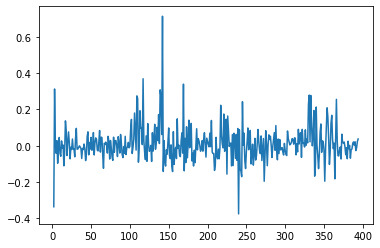

In [17]:
plt.plot(df['rets'])
plt.show()

In [18]:
std = df['rets'].std()
std

0.09513630945110547

In [20]:
type(df['close'].pct_change())

pandas.core.series.Series

In [101]:
def minimize_vol2(target_return, cryptos):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    
    n = len(cryptos)
    crypto_dict = {}
    for c in cryptos:
        crypto_dict[c] = get_crypto(c)

    rets_df = cryptodict_dfrets(crypto_dict)
    
    ann_rets = annualize_rets(rets_df)
    cov = rets_df.cov()
    
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n 
    
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (rets_df,),
                        'fun': lambda weights, rets_df: target_return - portfolio_return(weights,ann_rets)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    i = 0
    result = {}
    for x in weights.x:
        result[cryptos[i]] = x
        i += 1
    return result

In [102]:
minimize_vol2(.55,['btc','eth'])

{'btc': 0.6312863384247105, 'eth': 0.3687136615752895}